In [1]:
from lanegcn import ActorNet, actor_gather
import os
import argparse
import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number
import torch
from torch.utils.data import Sampler, DataLoader
from utils import Logger, load_pretrain
from lanegcn import get_model
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import sparse
import os
import copy
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from skimage.transform import rotate

config, Dataset, collate_fn, net, loss, post_process, opt = get_model()

In [2]:
avl = ArgoverseForecastingLoader('./dataset/train_mini/data')

In [3]:
print(avl)

Seq : /home/zzyu/GraphGAN/dataset/train_mini/data/88.csv
        ----------------------
        || City: MIA
        || # Tracks: 81
        ----------------------


In [4]:
avl.seq_list = sorted(avl.seq_list)
print(avl.seq_list)

[PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/1.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/10.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/101.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/103.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/104.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/105.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/106.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/107.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/108.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/109.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/110.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/111.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/112.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/113.csv'), PosixPath('/home/zzyu/GraphGAN/dataset/train_mini/data/115.csv'), PosixPath('/

In [5]:
print(avl[0])
print(avl[1])

Seq : /home/zzyu/GraphGAN/dataset/train_mini/data/1.csv
        ----------------------
        || City: PIT
        || # Tracks: 12
        ----------------------
Seq : /home/zzyu/GraphGAN/dataset/train_mini/data/10.csv
        ----------------------
        || City: MIA
        || # Tracks: 101
        ----------------------


In [6]:
import os

import argparse
import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number

import torch
from torch.utils.data import Sampler, DataLoader


from utils import Logger, load_pretrain
import matplotlib.pyplot as plt
from lanegcn import get_model

In [7]:
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()

In [8]:
def worker_init_fn(pid):
    np_seed = int(pid)
    np.random.seed(np_seed)
    random_seed = np.random.randint(2 ** 32 - 1)
    random.seed(random_seed)

dataset = Dataset('./dataset/preprocess/train_crs_dist6_angle90.p', config, train=True)
train_loader = DataLoader(
        dataset,
        batch_size=config["batch_size"],
        num_workers=config["workers"],
        shuffle=False,   # True: At each epoch, reorder the data
        collate_fn=collate_fn,
        pin_memory=True,
        worker_init_fn=worker_init_fn,   # The next 36 were thrown away
        drop_last=True,
    )

In [9]:
from symbol import break_stmt


data = {}
for i, data in enumerate(train_loader):
    data = dict(data)
    break
    


print(data.keys())

dict_keys(['city', 'orig', 'gt_preds', 'has_preds', 'theta', 'rot', 'feats', 'ctrs', 'graph', 'trajs2', 'traj1'])


LaneGCN

In [10]:
import numpy as np
import os
import sys
from fractions import gcd
from numbers import Number

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from data import ArgoDataset, collate_fn
from utils import gpu, to_long,  Optimizer, StepLR

from layers import Conv1d, Res1d, Linear, LinearRes, Null
from numpy import float64, ndarray
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from lanegcn import ActorNet, PredNet, MapNet, A2A, A2M, M2A, M2M, graph_gather, actor_gather
pred_net = PredNet(config)

actor_net = ActorNet(config)
map_net = MapNet(config)
a2m = A2M(config)
m2m = M2M(config)
m2a = M2A(config)
a2a = A2A(config)

# construct actor feature
actors, actor_idcs = actor_gather(data["feats"])
actor_ctrs = data["ctrs"]
actors = actor_net(actors)
# construct map features
graph = graph_gather(to_long(data["graph"]))
nodes, node_idcs, node_ctrs = map_net(graph)
nodes = a2m(nodes, graph, actors, actor_idcs, actor_ctrs)
nodes = m2m(nodes, graph)
actors = m2a(actors, actor_idcs, actor_ctrs, nodes, node_idcs, node_ctrs)
actors = a2a(actors, actor_idcs, actor_ctrs)

# prediction
out = pred_net(actors, actor_idcs, actor_ctrs)
rot, orig = data["rot"], data["orig"]

dict_keys(['cls', 'reg'])
32
torch.Size([6, 6, 30, 2])
torch.Size([30, 2])
tensor([[-1.8242,  0.1444],
        [ 0.7545,  2.1250],
        [-0.1181,  0.2016],
        [-0.3440,  0.8296],
        [ 1.2942,  1.1487],
        [-0.7077,  0.5549],
        [-0.5429, -1.0416],
        [-0.5303,  1.0946],
        [ 1.7767, -0.0841],
        [ 2.2620,  1.6975],
        [-0.7436,  1.1287],
        [ 0.4251,  1.6121],
        [ 2.8390, -2.5586],
        [-1.8569,  1.2222],
        [-1.3943, -0.1708],
        [ 0.1393, -0.6509],
        [-1.1310, -1.7862],
        [ 0.0273,  0.6874],
        [-0.9153, -2.6340],
        [ 5.0883, -1.5485],
        [-0.4681, -1.5203],
        [ 0.8871, -1.0394],
        [ 0.4524,  1.1874],
        [-0.2758,  0.9658],
        [-0.9146,  0.2014],
        [-0.8217,  0.8936],
        [ 0.4168, -2.6325],
        [-0.0172,  0.7263],
        [-1.0036, -1.8694],
        [ 1.6951, -0.5978]], grad_fn=<SelectBackward0>)


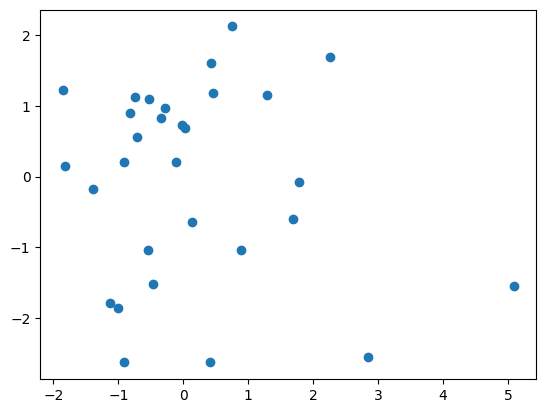

In [11]:
print(out.keys())
print(len(out['reg']))
print(out['reg'][0].size())   # reg_size = n_actors, 6, 30, 2

reg_a0_k0 = out['reg'][0][0][0]
print(reg_a0_k0.size())
print(reg_a0_k0)
plt.scatter(reg_a0_k0.detach().numpy()[:,0], reg_a0_k0.detach().numpy()[:,1])

In [12]:
traj1 = data['traj1'][0]
print(traj1.size())
traj_obs = traj1[0][:,:2]
print(reg_a0_k0.detach().numpy().shape)

torch.Size([6, 20, 3])
(30, 2)


tensor([[-2.9350e+01,  6.9829e-01],
        [-2.7669e+01,  6.1824e-01],
        [-2.5916e+01,  6.1834e-01],
        [-2.4357e+01,  5.5848e-01],
        [-2.2825e+01,  5.2700e-01],
        [-2.1702e+01,  4.6982e-01],
        [-1.9933e+01,  5.3166e-01],
        [-1.8591e+01,  4.0418e-01],
        [-1.6941e+01,  4.2177e-01],
        [-1.5494e+01,  3.2554e-01],
        [-1.3866e+01,  3.1888e-01],
        [-1.2298e+01,  3.3105e-01],
        [-1.0726e+01,  2.0914e-01],
        [-9.3659e+00,  2.3968e-01],
        [-7.7486e+00,  1.7806e-01],
        [-6.1332e+00,  1.8612e-01],
        [-4.6353e+00,  7.5501e-02],
        [-2.7170e+00,  6.0393e-02],
        [-1.5915e+00,  3.3193e-08],
        [ 1.0266e-05, -1.8155e-06]])
tensor([[-1.8242,  0.1444],
        [ 0.7545,  2.1250],
        [-0.1181,  0.2016],
        [-0.3440,  0.8296],
        [ 1.2942,  1.1487],
        [-0.7077,  0.5549],
        [-0.5429, -1.0416],
        [-0.5303,  1.0946],
        [ 1.7767, -0.0841],
        [ 2.2620,  1.6975],

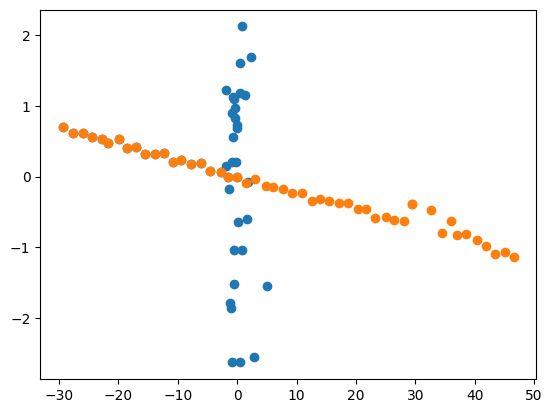

In [13]:
reg_a0_k0_all = torch.cat([traj_obs,reg_a0_k0])
print(traj_obs)
print(reg_a0_k0)
print(reg_a0_k0_all)
plt.scatter(reg_a0_k0_all.detach().numpy()[:,0],reg_a0_k0_all.detach().numpy()[:,1])

trajs2 = data['trajs2'][0]
plt.scatter(trajs2[0][:,0], trajs2[0][:,1])

In [14]:
print(data['traj1'][0][0].size())
print(out['reg'][0][0].size())

torch.Size([20, 3])
torch.Size([6, 30, 2])


torch.Size([20, 2]) torch.Size([30, 2])
torch.Size([50, 2])


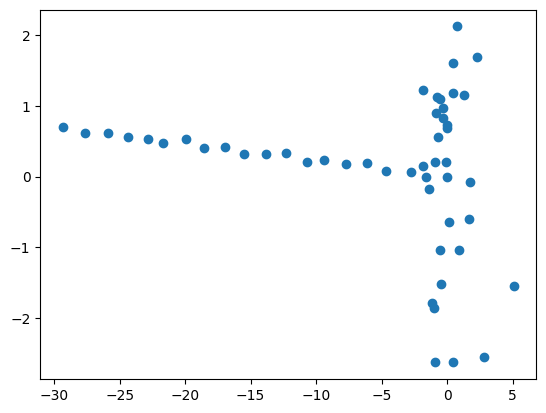

In [15]:
obs_traj_rel = data['traj1'][0][0][:,:2]
pred_traj_rel = out['reg'][0][0][0]

print(obs_traj_rel.size(), pred_traj_rel.size())
fake_traj_rel = torch.cat((obs_traj_rel,pred_traj_rel),dim=0)
print(fake_traj_rel.size())

plt.scatter(fake_traj_rel[:,0].detach().numpy(), fake_traj_rel[:,1].detach().numpy())

get_fake_traj

In [16]:
def actor_gather(actors: List[Tensor]) -> Tuple[Tensor, List[Tensor]]:
    batch_size = len(actors)
    num_actors = [len(x) for x in actors]

    actors = [x.transpose(1, 2) for x in actors]
    # print('x.transpose:', actors, len(actors), actors[0].size())
    actors = torch.cat(actors, 0)
    # print('cat:', actors)

    actor_idcs = []
    count = 0
    for i in range(batch_size):
        idcs = torch.arange(count, count + num_actors[i]).to(actors.device)
        actor_idcs.append(idcs)
        count += num_actors[i]
    return actors, actor_idcs

In [17]:
actors, actor_idcs = actor_gather(gpu(data["traj1"]))

In [18]:
a = 0
for i in range(len(data['traj1'])):
    a += data['traj1'][i].size(0)
print(a)

528


In [19]:
print(actors.size())
print(data['traj1'][0].size())

torch.Size([528, 3, 20])
torch.Size([6, 20, 3])


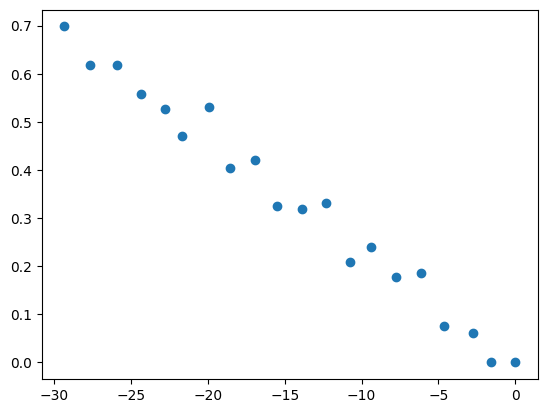

In [20]:
plt.scatter(data['traj1'][0][0][:,0],data['traj1'][0][0][:,1])

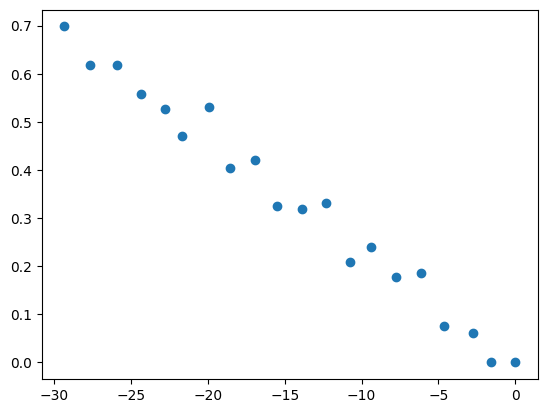

In [21]:
plt.scatter(actors[0][0],actors[0][1])

In [22]:
print(len(out['reg']), out['reg'][1].size())

32 torch.Size([27, 6, 30, 2])


torch.Size([528, 3, 20])
torch.Size([528, 6, 30, 2])
torch.Size([3168, 30, 2])
torch.Size([30]) torch.Size([30])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<SubBackward0>)
torch.Size([3168, 2, 30])
obs torch.Size([528, 2, 20])
torch.Size([3168, 2, 20])
c torch.Size([6, 20])
all torch.Size([3168, 2, 50])


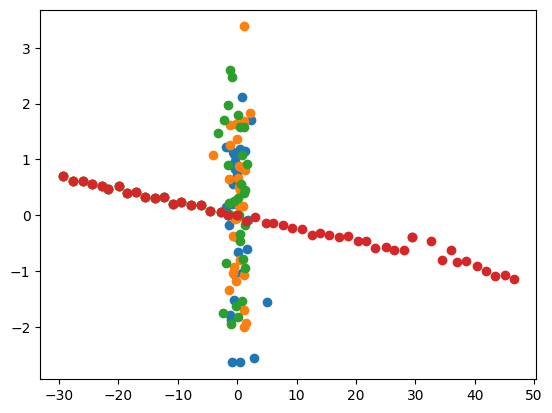

In [23]:
print(actors.size())
reg = torch.cat([x for x in out['reg']], 0)
print(reg.size())
reg1 = torch.cat([x for x in reg], 0)
print(reg1.size())

a = reg[0][0][:,0]
b = reg1[0][:,0]
print(a.size(), b.size())
print(a-b)

reg2 = reg1.transpose(1,2)
print(reg2.size())

obs_traj_rel = actors[:,:2]
print('obs', obs_traj_rel.size())

obs_traj_rel_repeat6= torch.repeat_interleave(obs_traj_rel, repeats=6, dim=0)

print(obs_traj_rel_repeat6.size())
c = obs_traj_rel_repeat6[0:6,0]
print('c',c.size())
d = obs_traj_rel[0,0]
# print(c - d)


all = torch.cat([obs_traj_rel_repeat6,reg2],dim=-1)
print('all', all.size())

plt.scatter(all[0,0].detach().numpy(),all[0,1].detach().numpy())
plt.scatter(all[1,0].detach().numpy(),all[1,1].detach().numpy())
plt.scatter(all[3,0].detach().numpy(),all[3,1].detach().numpy())
plt.scatter(data['trajs2'][0][0][:,0],data['trajs2'][0][0][:,1])

In [24]:
def get_fake_traj_rel(traj1:List[Tensor], reg:List[Tensor]) -> List[Tensor]:
    # obs gather and repeat 6
    obs_traj_rel, actor_idcs = actor_gather(gpu(traj1))
    obs_traj_rel1 = obs_traj_rel[:,:2]
    obs_traj_rel_repeat6= torch.repeat_interleave(obs_traj_rel1, repeats=6, dim=0)

    # reg cat
    reg0 = torch.cat([x for x in reg], 0)
    reg1 = torch.cat([x for x in reg0], 0)
    reg2 = reg1.transpose(1,2)

    fake_traj_rel = torch.cat([obs_traj_rel_repeat6,reg2],dim=-1)
    
    return fake_traj_rel

    

In [25]:
fake_traj_rel = get_fake_traj_rel(data['traj1'], out['reg'])

In [26]:
print(fake_traj_rel.size())

torch.Size([3168, 2, 50])


In [27]:
print(len(data['trajs2']))
print(data['trajs2'][0].size())
pred_traj_rel, actor_idcs = actor_gather(gpu(data['trajs2']))
print(pred_traj_rel.size())

pred_traj_rel1 = pred_traj_rel[:,:2]
print(pred_traj_rel1.size())

32
torch.Size([6, 50, 3])
torch.Size([528, 3, 50])
torch.Size([528, 2, 50])


In [28]:
def get_pred_traj_rel(trajs2):
    pred_traj_rel0, actor_idcs = actor_gather(gpu(trajs2))
    pred_traj_rel = pred_traj_rel0[:,:2]
    return pred_traj_rel
    
pred_traj_rel = get_pred_traj_rel(data['trajs2'])
print(pred_traj_rel.size())

torch.Size([528, 2, 50])


Discriminator

In [29]:
from lanegcn import ActorNet

In [30]:
actor_net = ActorNet(config)

actors, actor_idcs = actor_gather(gpu(data["feats"]))
print(actors.size())
actors = actor_net(actors)
print(actors.size())

print(pred_traj_rel.size())

torch.Size([528, 3, 20])
torch.Size([528, 128])
torch.Size([528, 2, 50])


In [31]:
from layers import Conv1d, Res1d, Linear, LinearRes, Null

In [32]:
norm = "GN"
ng = 1
n_in = 2
n_out = [32, 64, 128]
blocks = [Res1d, Res1d, Res1d]
num_blocks = [2, 2, 2]
groups = []
for i in range(len(num_blocks)):
    group = []
    if i == 0:
        group.append(blocks[i](n_in, n_out[i], norm=norm, ng=ng))
    else:
        group.append(blocks[i](n_in, n_out[i], stride=2, norm=norm, ng=ng))
    for j in range(1, num_blocks[i]):
        group.append(blocks[i](n_out[i], n_out[i], norm=norm, ng=ng))
    groups.append(nn.Sequential(*group))
    n_in = n_out[i]
groups = nn.ModuleList(groups)


n = config["n_actor"]
lateral = []
for i in range(len(n_out)):
    lateral.append(Conv1d(n_out[i], n, norm=norm, ng=ng, act=False))
lateral = nn.ModuleList(lateral)
output = Res1d(n, n, norm=norm, ng=ng)

In [33]:
print(groups)

ModuleList(
  (0): Sequential(
    (0): Res1d(
      (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
      (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
      (downsample): Sequential(
        (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,), bias=False)
        (1): GroupNorm(1, 32, eps=1e-05, affine=True)
      )
    )
    (1): Res1d(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
      (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
    )
  )
  (1): Sequential(
    (0): Res1d(
      (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      

In [34]:
print(lateral)

ModuleList(
  (0): Conv1d(
    (conv): Conv1d(32, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (norm): GroupNorm(1, 128, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
  )
  (1): Conv1d(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (norm): GroupNorm(1, 128, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
  )
  (2): Conv1d(
    (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (norm): GroupNorm(1, 128, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
  )
)


In [35]:
out = pred_traj_rel
print(out.size())
outputs = []
for i in range(len(groups)):
    print(i)
    out = groups[i](out)
    outputs.append(out)
out = lateral[-1](outputs[-1])

torch.Size([528, 2, 50])
0
1
2


In [36]:
out = pred_traj_rel
out = groups[0](out)

In [37]:
print(groups[0])

Sequential(
  (0): Res1d(
    (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (relu): ReLU(inplace=True)
    (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
    (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
    (downsample): Sequential(
      (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,), bias=False)
      (1): GroupNorm(1, 32, eps=1e-05, affine=True)
    )
  )
  (1): Res1d(
    (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (relu): ReLU(inplace=True)
    (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
    (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
  )
)


In [38]:
print(out.size())

torch.Size([528, 32, 50])


In [39]:
for i in range(len(outputs) - 2, -1, -1):
    out = F.interpolate(out, scale_factor=2, mode="linear", align_corners=False)
    break

In [40]:
print(out.size())
print(lateral[0](outputs[0]).size())

torch.Size([528, 32, 100])
torch.Size([528, 128, 50])


In [41]:
print(pred_traj_rel.size())

torch.Size([528, 2, 50])


In [42]:
def make_mlp(dim_list, activation='relu', batch_norm=True, dropout=0):
    layers = []
    for dim_in, dim_out in zip(dim_list[:-1], dim_list[1:]):
        layers.append(nn.Linear(dim_in, dim_out))
        if batch_norm:
            layers.append(nn.BatchNorm1d(dim_out))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        if dropout > 0:
            layers.append(nn.Dropout(p=dropout))
    return nn.Sequential(*layers)

real_classifier_dims = [128, 1024, 1]
real_classifier = make_mlp(real_classifier_dims)

In [43]:
print(real_classifier)

Sequential(
  (0): Linear(in_features=128, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=1, bias=True)
  (4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
)


In [45]:
from lanegcn import TrajectoryDiscriminator
discriminator = TrajectoryDiscriminator(config)
scores = discriminator(pred_traj_rel)
print(scores.size())

torch.Size([528, 1])


discriminator_step

In [47]:
import torch
import random


def bce_loss(input, target):
    neg_abs = -input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()




def gan_g_loss(scores_fake):
    y_fake = torch.ones_like(scores_fake) * random.uniform(0.7, 1.2)
    return bce_loss(scores_fake, y_fake)




def gan_d_loss(scores_real, scores_fake):
    y_real = torch.ones_like(scores_real) * random.uniform(0.7, 1.2)
    y_fake = torch.ones_like(scores_fake) * random.uniform(0, 0.3)
    loss_real = bce_loss(scores_real, y_real)
    loss_fake = bce_loss(scores_fake, y_fake)
    return loss_real + loss_fake

In [46]:
scores_fake = discriminator(fake_traj_rel)
scores_real = discriminator(pred_traj_rel)

In [49]:
loss = torch.zeros(1)
print(loss.size())

torch.Size([1])


In [ ]:
losses = {}
loss = torch.zeros(1).to(pred_traj_gt)

g_loss_fn = gan_g_loss
d_loss_fn = gan_d_loss

opt_g = optim.Adam(generator.parameters(), lr=args.g_learning_rate)
opt_d = optim.Adam(discriminator.parameters(), lr=args.d_learning_rate)


# Maybe restore from checkpoint
optimizer_g.load_state_dict(checkpoint['g_optim_state'])
optimizer_d.load_state_dict(checkpoint['d_optim_state'])

# Save another checkpoint with model weights and optimizer state
checkpoint['g_optim_state'] = optimizer_g.state_dict()
checkpoint['d_optim_state'] = optimizer_d.state_dict()


# Compute loss with optional gradient penalty
data_loss = d_loss_fn(scores_real, scores_fake)
losses['D_data_loss'] = data_loss.item()
loss += data_loss
losses['D_total_loss'] = loss.item()
opt.zero_grad()
loss.backward()
if args.clipping_threshold_d > 0:
    nn.utils.clip_grad_norm_(discriminator.parameters(),
                             args.clipping_threshold_d)
opt.step()